# Signal Processing Project: real-time sound localisation

## 1 Offline system
### 1.1 Data generation and dataset

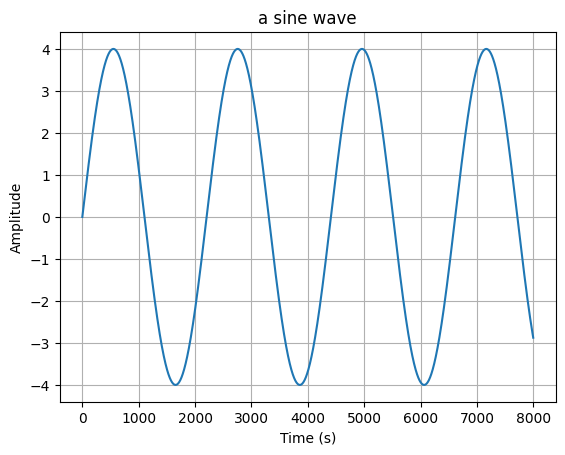

In [4]:
import numpy as np
import matplotlib.pyplot as plt


def create_sine_wave(f, A, fs, N):
    n = np.arange(0, N)
    out = A * np.sin(2 * np.pi * f * n / fs)
    return out


# call and test your function here #
fs = 44100
N = 8000
freq = 20
amplitude = 8 / 2  # 8 being the peak to peak amplitude
sine_wave = create_sine_wave(freq, amplitude, fs, N)
t = np.arange(0, N)

plt.title("a sine wave")
plt.plot(t, sine_wave)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
# plt.margins(x=0, y=0)
plt.grid()
plt.show()

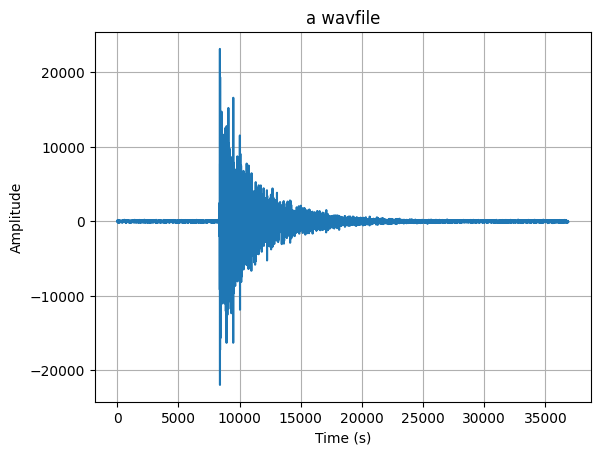

In [3]:
from glob import glob
import scipy.io.wavfile as wf
import matplotlib.pyplot as plt


def read_wavefile(path):
    out = wf.read(path)
    return out


# call and test your function here #
LocateClaps = "./resources/LocateClaps"
files = glob(f"{LocateClaps}/*.wav")
for file in files:
    read_wavefile(file)

plt.title("a wavfile")
plt.plot(read_wavefile(files[0])[1])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
# plt.margins(x=0, y=0)
plt.grid()
plt.show()

### 1.2 Buffering

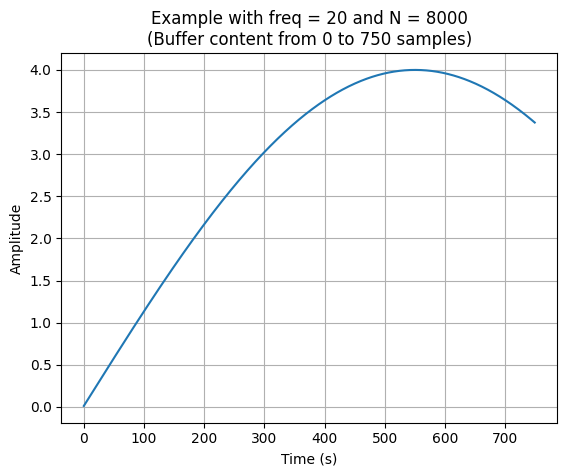

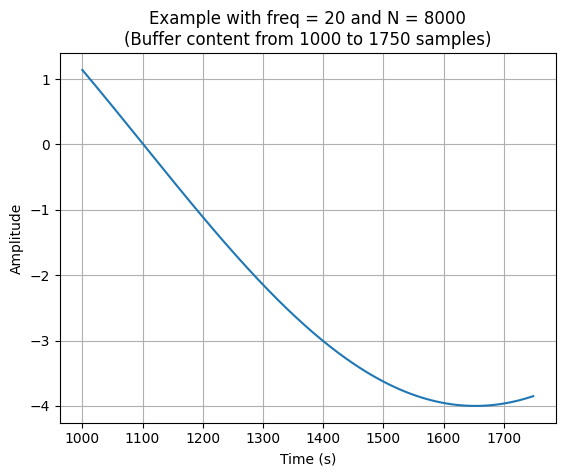

In [10]:
from collections import deque
import matplotlib.pyplot as plt


def create_ringbuffer(maxlen):
    out = deque(maxlen=maxlen)
    return out


# call and test your function here #
stride = 1000
maxlen = 750
ringbuffer = create_ringbuffer(maxlen)
sine_wave = create_sine_wave(20, 8 / 2, 44100, 8000)
# reading your signal as a stream:
for i, sample in enumerate(sine_wave):
    ringbuffer.append(sample)
    if i == ringbuffer.maxlen:
        t = np.arange(0, 750)

        plt.title("Example with freq = 20 and N = 8000\n(Buffer content from 0 to 750 samples)")
        plt.plot(t, ringbuffer)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        # plt.margins(x=0, y=0)
        plt.grid()
        plt.show()
    if i == ringbuffer.maxlen + stride:
        t = np.arange(1000, 1750)

        plt.title("Example with freq = 20 and N = 8000\n(Buffer content from 1000 to 1750 samples)")
        plt.plot(t, ringbuffer)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        # plt.margins(x=0, y=0)
        plt.grid()
        plt.show()

### 1.3 Pre-processing
#### 1.3.1 Normalisation

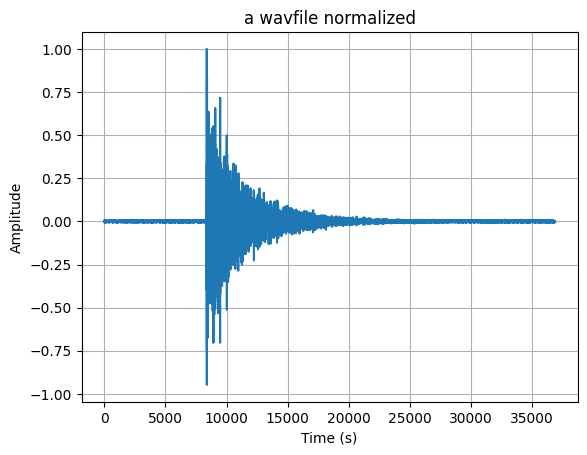

In [11]:
import matplotlib.pyplot as plt


def normalise(s):
    out = s/max(abs(s))
    return out


# call and test your function here #
signal = read_wavefile(files[0])[1]
normalised_signal = normalise(signal)

plt.title("a wavfile normalized")
plt.plot(normalised_signal)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
# plt.margins(x=0, y=0)
plt.grid()
plt.show()

#### 1.3.2 Downsampling

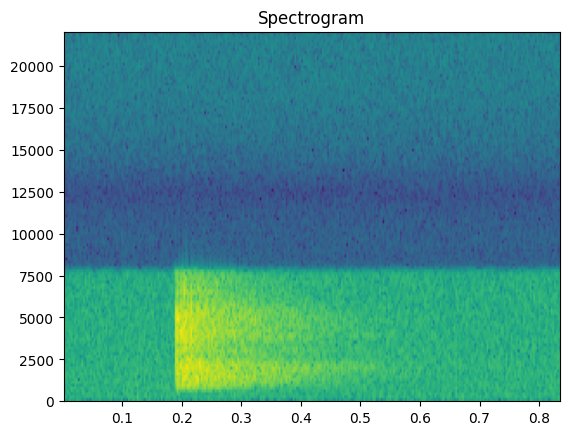

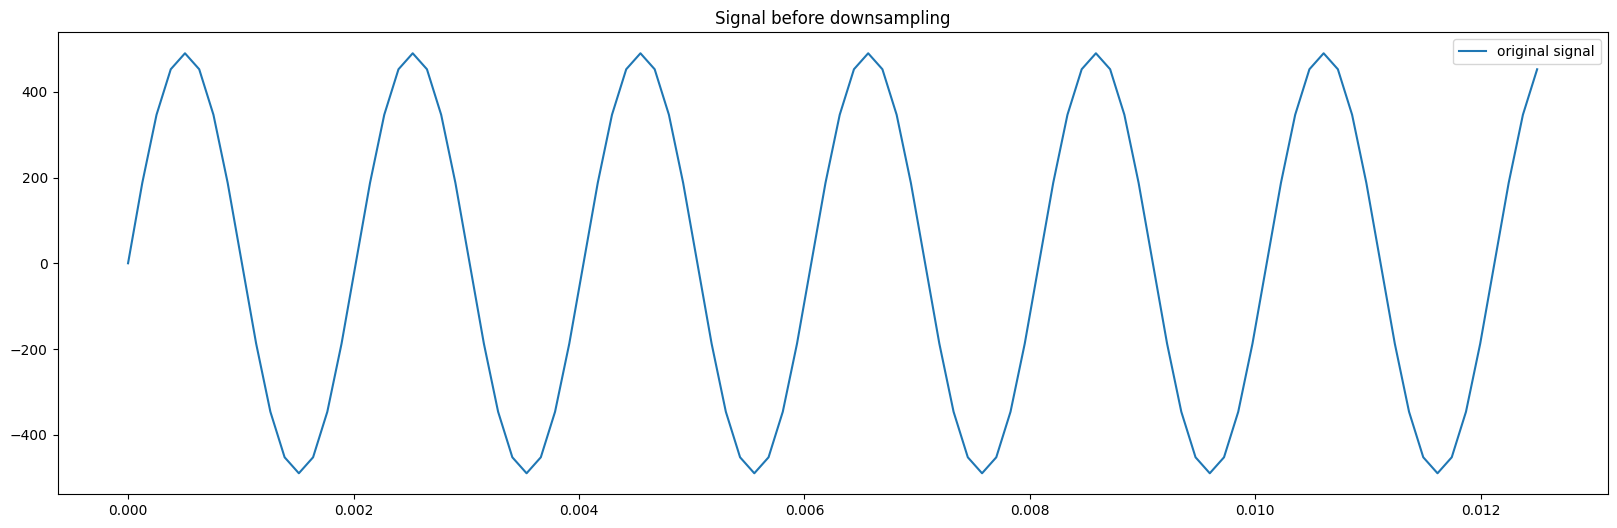

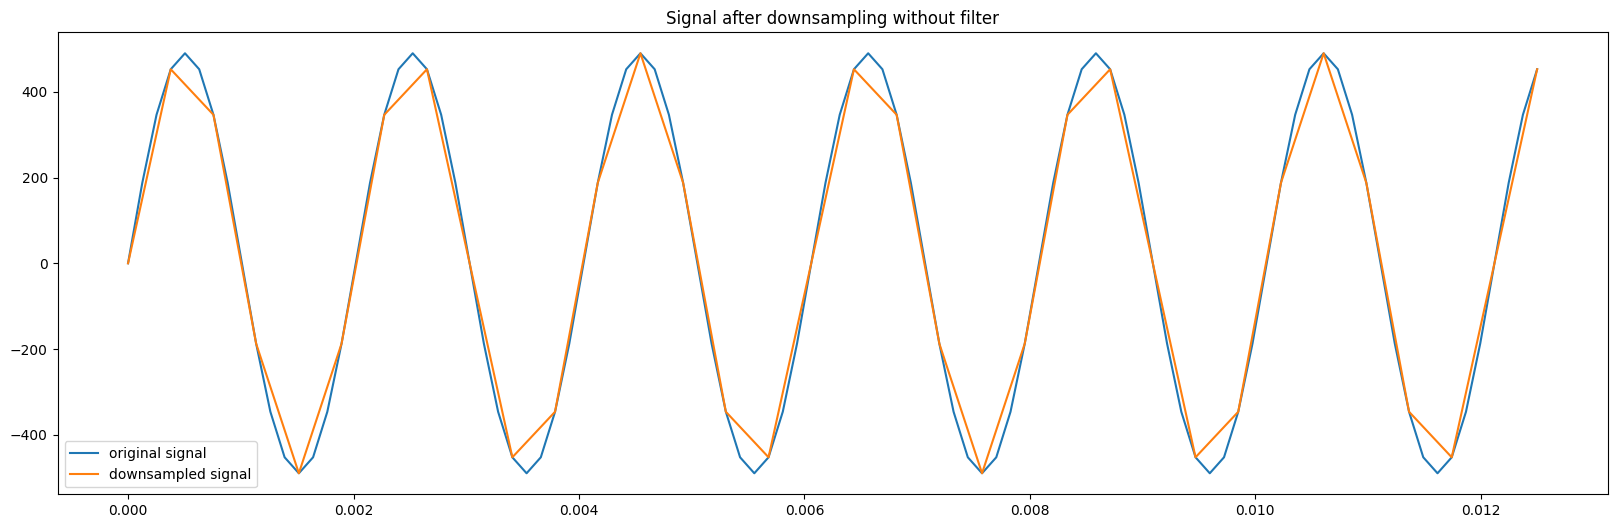

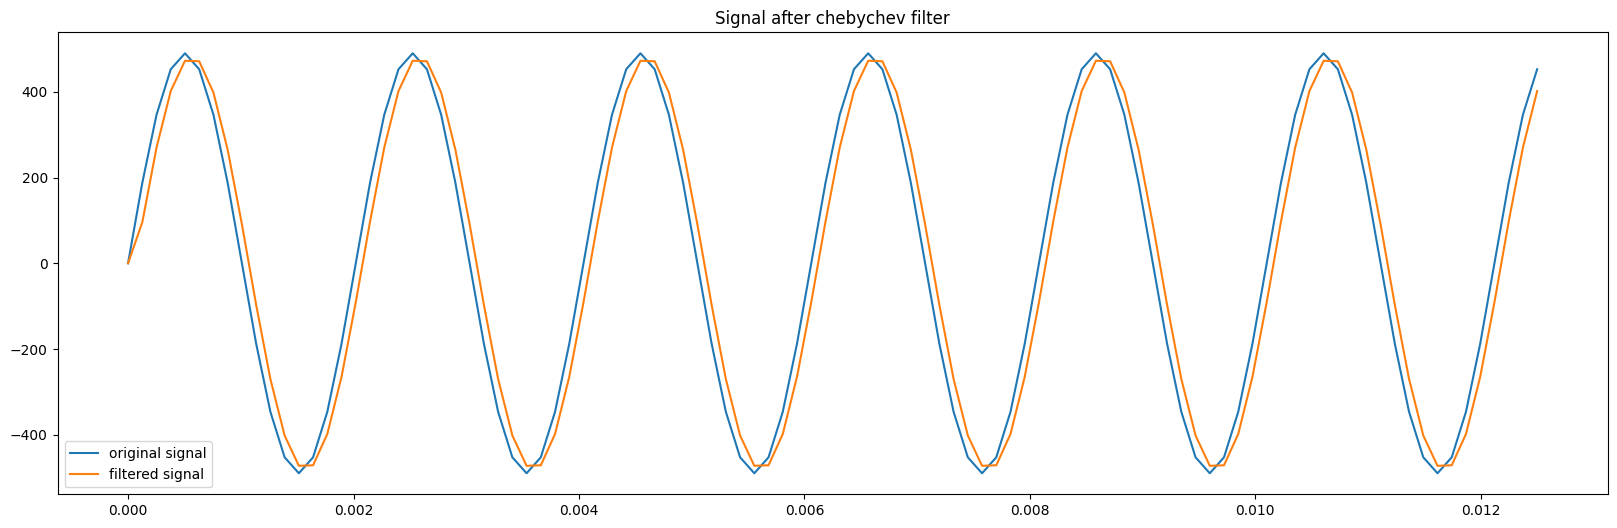

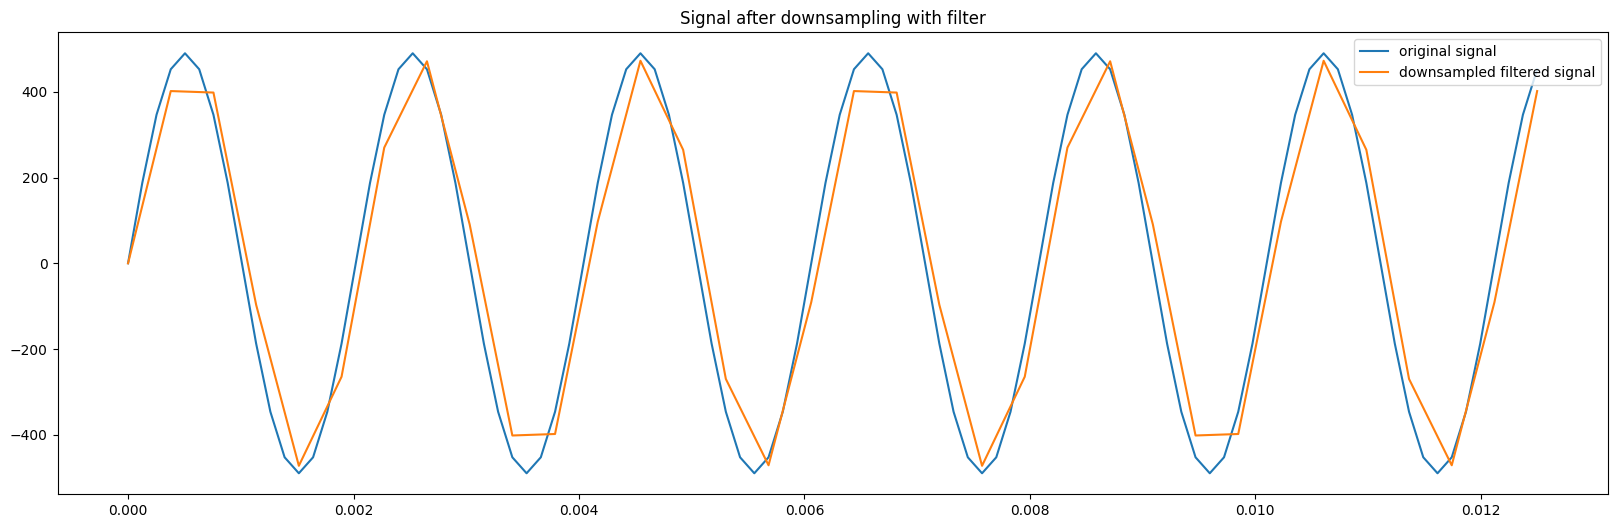

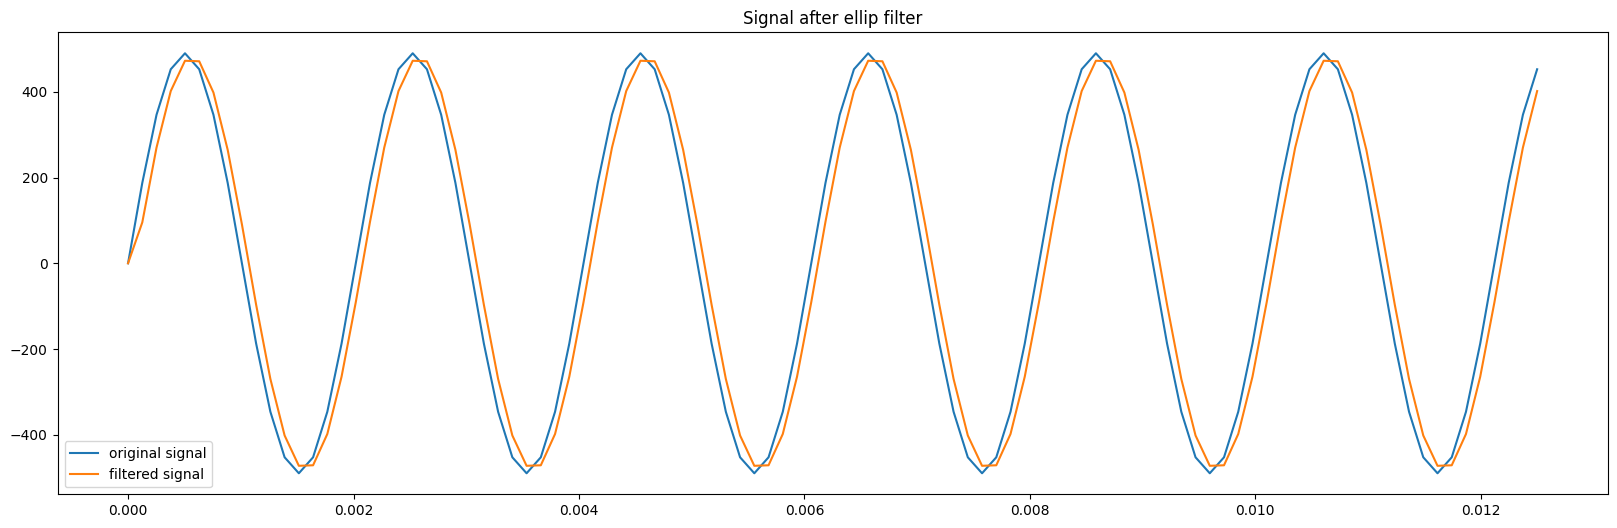

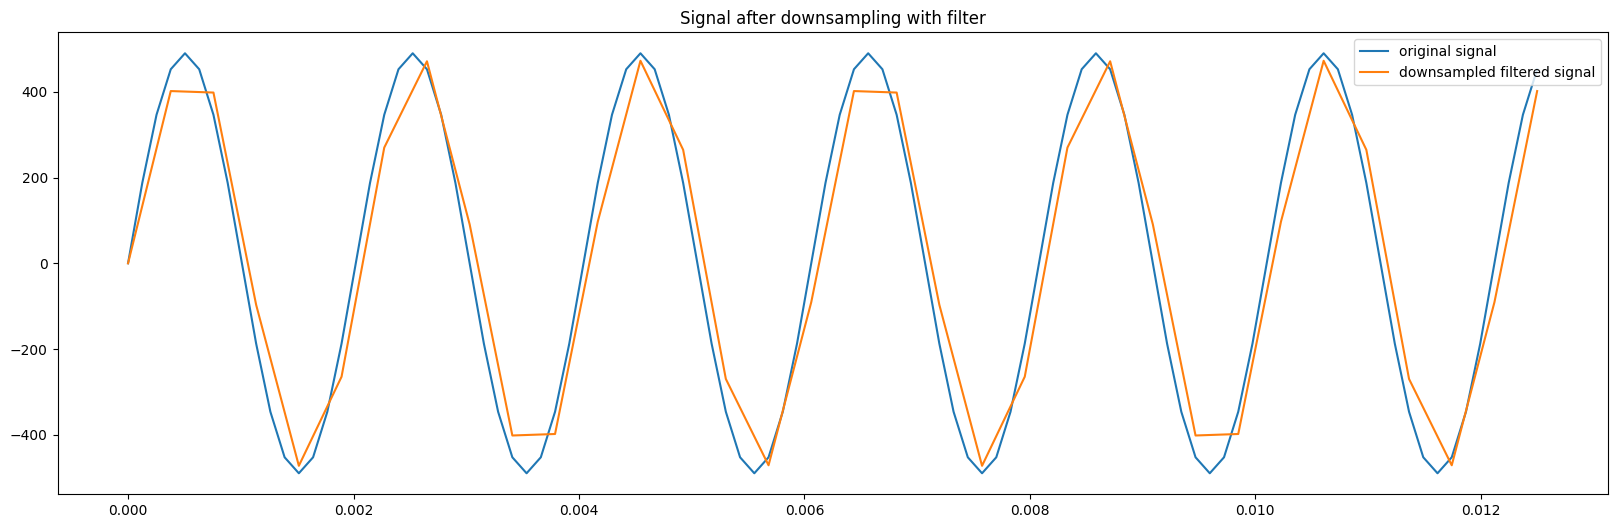

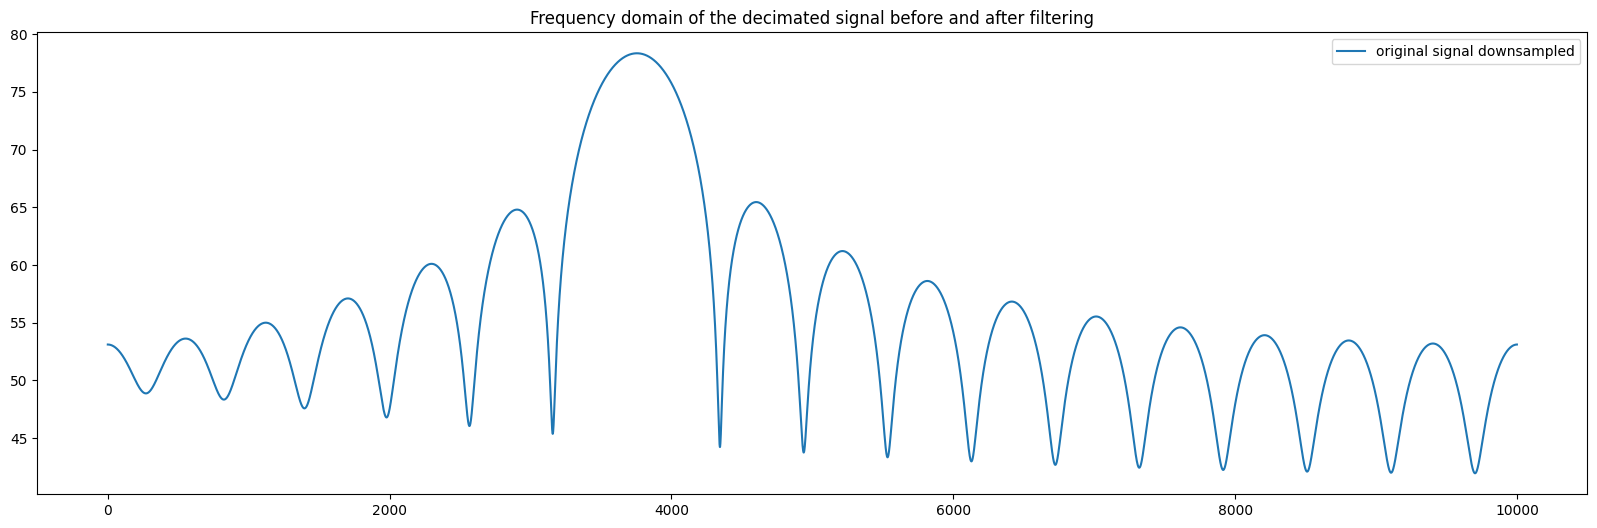

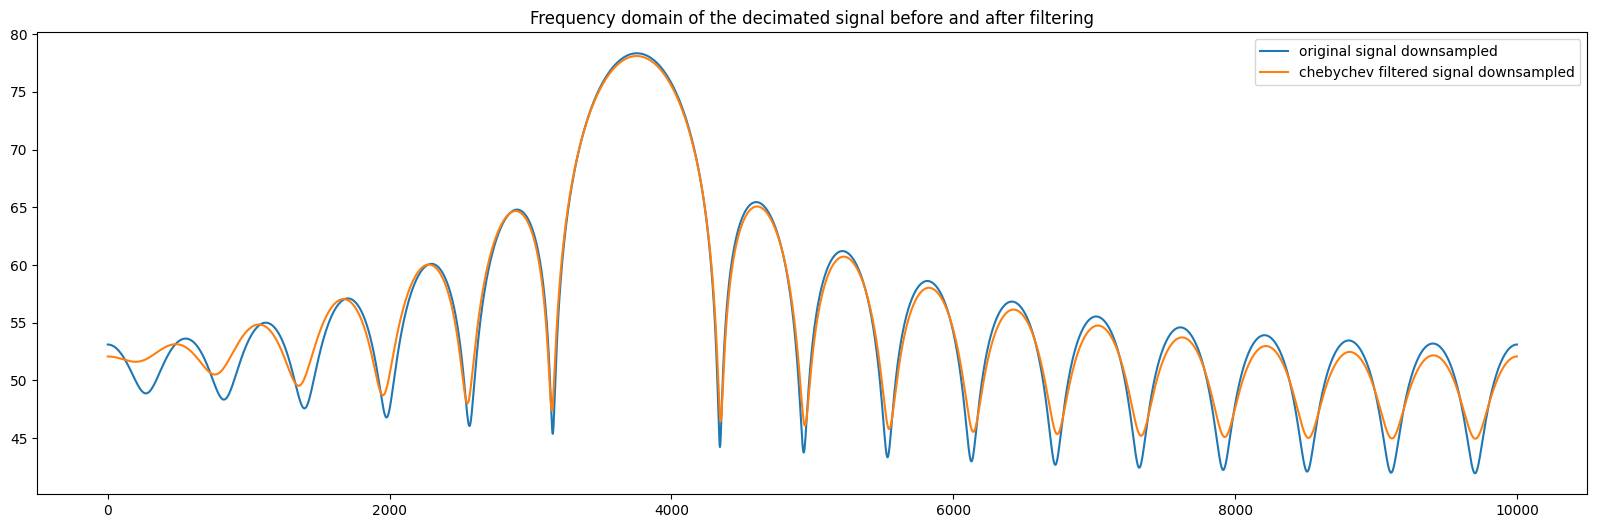

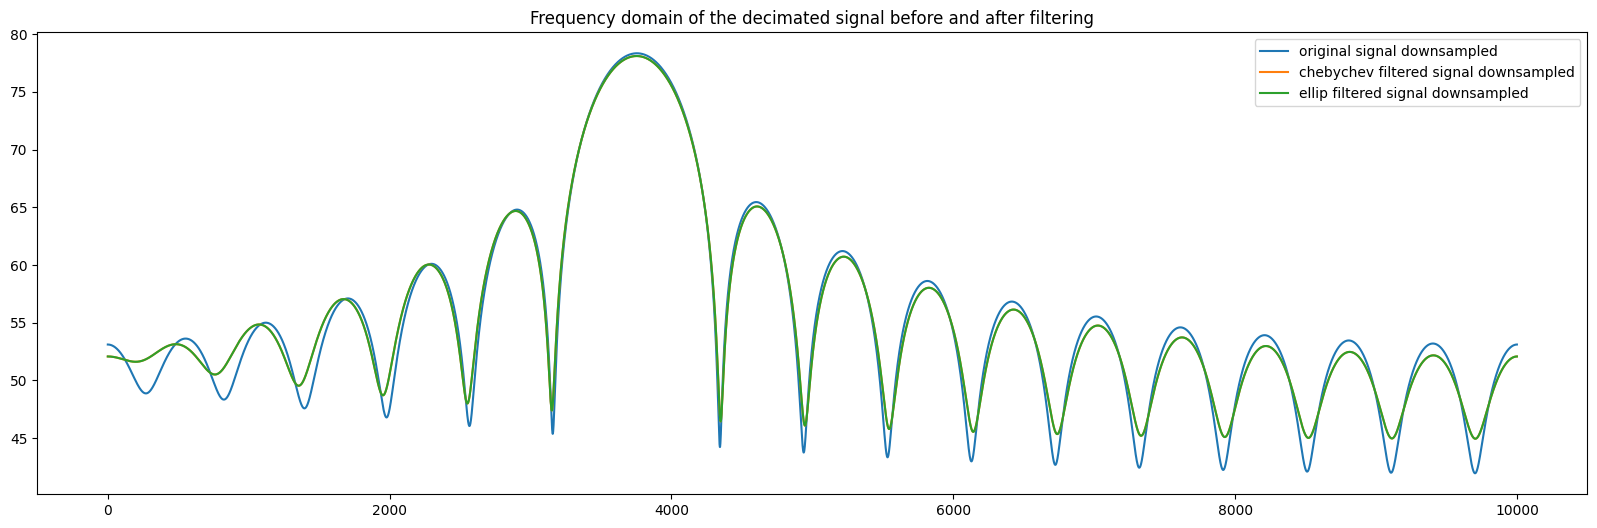

In [12]:
from scipy import signal as sig

## 1 - spectral analysis via spectrogram
signal = read_wavefile(files[0])[1]
plt.specgram(signal, Fs=44100)
plt.title("Spectrogram")
plt.show()
"""1.3.2.1 [PAPER]
On va garder une fréquence d'échantillonnage de 8000 Hz car les spectrogrammes observés ne dépassent pas
environ 8000Hz"""


## 2 - Anti-aliasing filter synthesis
def create_filter_cheby(wp, ws, gpass, gstop, fs):
    # we need the chebychev order first
    cheby_order, wn = sig.cheb1ord(wp, ws, gpass, gstop, fs)
    # then we can create the filter
    B, A = sig.cheby1(cheby_order, gpass, wn)
    return B, A


def create_filter_cauer(wp, ws, gpass, gstop, fs):
    # we need the ellip order first
    ellip_order, wn = sig.ellipord(wp, ws, gpass, gstop, fs)
    # then we can create the filter
    B, A = sig.ellip(ellip_order, gpass, gstop, wn)
    return B, A


## 3 - Decimation
def downsampling(sig, B, A, M):
    # we need to filter the signal first
    wp = 0.01
    ws = fs/2
    gpass = 0.001
    gstop = 40
    filtered_signal = create_filter_cauer(wp, ws, gpass, gstop, fs)
    out = filtered_signal[::M]
    return out


# call and test your function here
# testing the filters
fs = 8000
N = 100
signal1 = create_sine_wave(8500, 1000/2, fs, N)
signal2 = create_sine_wave(7500, 20/2, fs, N)
signal = signal1 + signal2
plt.figure(figsize=(20, 6))
time_inter = N / fs
time_vector = np.linspace(0, time_inter, N)
plt.plot(time_vector, signal)
plt.legend(["original signal"])
plt.title("Signal before downsampling")
plt.show()
# downsampling
M = 3
downsampled_signal = signal[::M]
plt.figure(figsize=(20, 6))
plt.title("Signal after downsampling without filter")
plt.plot(time_vector, signal)
plt.plot(time_vector[::M], downsampled_signal)
plt.legend(["original signal", "downsampled signal"])
plt.show()
# chebychev filter
wp = 0.01
ws = fs/2
gpass = 0.001
gstop = 40
B, A = create_filter_cheby(wp, ws, gpass, gstop, fs)
filtered_signal = sig.lfilter(B, A, signal)
plt.figure(figsize=(20, 6))
plt.title("Signal after chebychev filter")
plt.plot(time_vector, signal)
plt.plot(time_vector, filtered_signal)
plt.legend(["original signal", "filtered signal"])
plt.show()
# downsampling with filter
M = 3
downsampled_signal = filtered_signal[::M]
plt.figure(figsize=(20, 6))
plt.title("Signal after downsampling with filter")
plt.plot(time_vector, signal)
plt.plot(time_vector[::M], downsampled_signal)
plt.legend(["original signal", "downsampled filtered signal"])
plt.show()

# ellip filter
wp = 0.01
ws = fs/2
gpass = 0.001
gstop = 40
B, A = create_filter_cauer(wp, ws, gpass, gstop, fs)
filtered_signal = sig.lfilter(B, A, signal)
plt.figure(figsize=(20, 6))
plt.title("Signal after ellip filter")
plt.plot(time_vector, signal)
plt.plot(time_vector, filtered_signal)
plt.legend(["original signal", "filtered signal"])
plt.show()
# downsampling with filter
M = 3
downsampled_signal = filtered_signal[::M]
plt.figure(figsize=(20, 6))
plt.title("Signal after downsampling with filter")
plt.plot(time_vector, signal)
plt.plot(time_vector[::M], downsampled_signal)
plt.legend(["original signal", "downsampled filtered signal"])
plt.show()

# showing the frequency domains
downsampled_signal = signal[::M]
freq_base = np.fft.fft(downsampled_signal, 20000)
freq_base = 20 * np.log10(np.abs(freq_base))
# we take half of that
freq_base = freq_base[:len(freq_base)//2]

B, A = create_filter_cheby(wp, ws, gpass, gstop, fs)
cheby_sig = sig.lfilter(B, A, signal)
downsampled_signal = cheby_sig[::M]
freq_anti_alliazed_cheby = np.fft.fft(downsampled_signal, 20000)
freq_anti_alliazed_cheby = 20 * np.log10(np.abs(freq_anti_alliazed_cheby))
# we take half of that
freq_anti_alliazed_cheby = freq_anti_alliazed_cheby[:len(freq_anti_alliazed_cheby)//2]

B, A = create_filter_cauer(wp, ws, gpass, gstop, fs)
cauer_sig = sig.lfilter(B, A, signal)
downsampled_signal = cauer_sig[::M]
freq_anti_alliazed_ellip = np.fft.fft(downsampled_signal, 20000)
freq_anti_alliazed_ellip = 20 * np.log10(np.abs(freq_anti_alliazed_ellip))
# we take half of that
freq_anti_alliazed_ellip = freq_anti_alliazed_ellip[:len(freq_anti_alliazed_ellip)//2]


plt.figure(figsize=(20, 6))
plt.title("Frequency domain of the decimated signal before and after filtering")
plt.plot(freq_base)
#plt.plot(freq_anti_alliazed_cheby)
#plt.plot(freq_anti_alliazed_ellip)
plt.legend(["original signal downsampled", "chebychev filtered signal downsampled", "ellip filtered signal downsampled"])
plt.show()
plt.figure(figsize=(20, 6))
plt.title("Frequency domain of the decimated signal before and after filtering")
plt.plot(freq_base)
plt.plot(freq_anti_alliazed_cheby)
#plt.plot(freq_anti_alliazed_ellip)
plt.legend(["original signal downsampled", "chebychev filtered signal downsampled", "ellip filtered signal downsampled"])
plt.show()
plt.figure(figsize=(20, 6))
plt.title("Frequency domain of the decimated signal before and after filtering")
plt.plot(freq_base)
plt.plot(freq_anti_alliazed_cheby)
plt.plot(freq_anti_alliazed_ellip)
plt.legend(["original signal downsampled", "chebychev filtered signal downsampled", "ellip filtered signal downsampled"])
plt.show()
# they are the same pictures

### 1.4 Cross-correlation

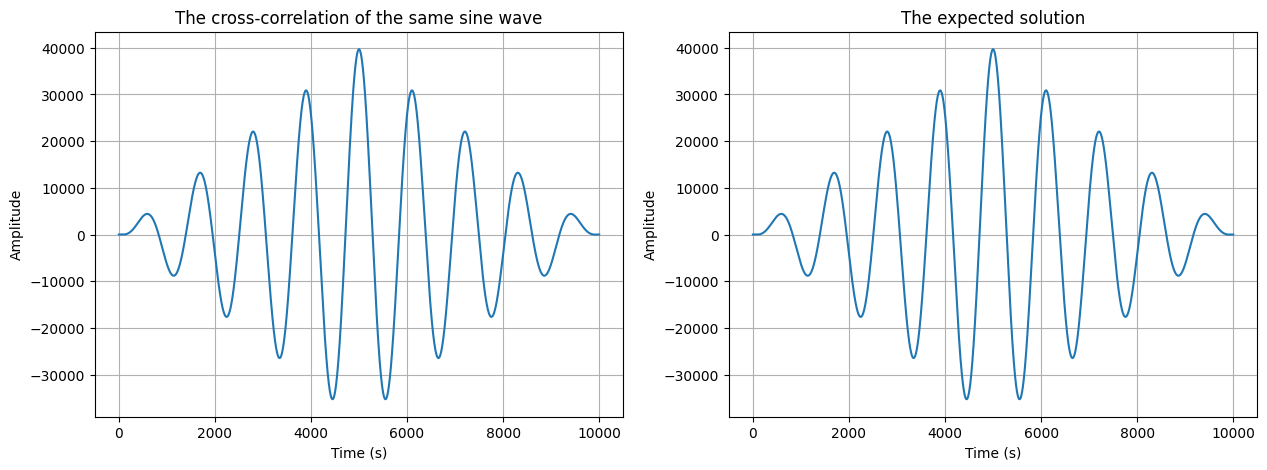

In [15]:
## 1.4
import scipy.signal as sc
import numpy as np


def fftxcorr(in1, in2):
    input1 = np.asarray(in1)
    input2 = np.asarray(in2)
    input1 = np.append(input1, np.zeros(len(in2)))
    input2 = np.append(np.zeros(len(in1)), input2)
    out = np.fft.ifft(np.fft.fft(input1) * np.conj(np.fft.fft(input2))).real
    return out  # sc.correlate(in1, in2, 'full')

    
# call and test your function here #
sine_wave = create_sine_wave(40, 4, 44100, 5000)
xcorr_fft = fftxcorr(sine_wave, sine_wave)
xcorr_fftconv = sc.fftconvolve(sine_wave, sine_wave[::-1], 'full') # [::-1] flips the signal but you can also use np.flip()

'''REMARQUE
len(xcorr_fft) = 10000 et len(xcorr_fftconv) = 9999,
en particulier xcorr_fft[1].
'''

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("The cross-correlation of the same sine wave")
plt.plot(xcorr_fft)
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
# plt.margins(x=0, y=0)
plt.subplot(1, 2, 2)
plt.title("The expected solution")
plt.plot(xcorr_fftconv)
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
# plt.margins(x=0, y=0)
plt.show()

### 1.5 Localisation
#### 1.5.1 TDOA

In [ ]:
def TDOA(xcorr):
    
    # your code here #

    return out

#### 1.5.2 Equation system

In [ ]:
from scipy.optimize import root

# mic coordinates in meters
MICS = [{'x': 0, 'y': 0.0487}, {'x': 0.0425, 'y': -0.025}, {'x': -0.0425, 'y': -0.025}] 

def equations(p, deltas):
    v = 343
    x, y = p
    eq1 = v*deltas[0] - np.sqrt((MICS[0]['x'] - x)**2 + (MICS[0]['y'] - y)**2) + np.sqrt((MICS[1]['x'] - x)**2 + (MICS[1]['y'] - y)**2)
    eq2 = v*deltas[1] - np.sqrt((MICS[0]['x'] - x)**2 + (MICS[0]['y'] - y)**2) + np.sqrt((MICS[2]['x'] - x)**2 + (MICS[2]['y'] - y)**2)
    return (eq1, eq2)
    
def localize_sound(deltas):

    sol = root(equations, [0, 0], (deltas), tol=10)
    return sol.x

def source_angle(coordinates):
    
    # your code here

    return out

# call and test your function here #

### 1.6 System accuracy and speed

In [2]:
## 1.6.1
def accuracy(pred_angle, gt_angle, threshold):
    
    # your code here #

    return out

## 1.6.2
possible_angle = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
for angle in possible_angle:
    for f in files:
        if f'_{angle}.' in f:
            mic = f.split('/')[-1].split('_')[0] #if '/' does not work, use "\\" (windows notation)
            
# call and test your function here #

## 1.6.3
from time import time_ns, sleep

def func_example(a, b):
    return a*b

def time_delay(func, args):
    start_time = time_ns()
    out = func(*args)
    end_time = time_ns()
    print(f"{func.__name__} in {end_time - start_time} ns")
    return out

product = time_delay(func_example, [2, 10])

# call and test your previous functions here #

## 2 Real-time localisation

### 2.1 Research one Raspberry Pi application

### 2.2 Data acquisition and processing

In [ ]:
#### Callback 
import pyaudio

RESPEAKER_CHANNELS = 8
BUFFERS = []

def callback(in_data, frame_count, time_info, flag):
    global BUFFERS
    data = np.frombuffer(in_data, dtype=np.int16)
    BUFFERS[0].extend(data[0::RESPEAKER_CHANNELS])
    BUFFERS[1].extend(data[2::RESPEAKER_CHANNELS])
    BUFFERS[2].extend(data[4::RESPEAKER_CHANNELS])
    return (None, pyaudio.paContinue)

#### Stream management

RATE = 44100
RESPEAKER_WIDTH = 2
CHUNK_SIZE = 2048

def init_stream():
    print("========= Stream opened =========")
    p = pyaudio.PyAudio()
    for i in range(p.get_device_count()):
        device_info = p.get_device_info_by_index(i)

        if device_info['maxInputChannels'] == 8:
            INDEX = i
            break

        if i == p.get_device_count()-1:
            # Sound card not found
            raise OSError('Invalid number of channels')

    stream = p.open(rate=RATE, channels=RESPEAKER_CHANNELS, format=p.get_format_from_width(RESPEAKER_WIDTH), input=True, input_device_index=INDEX,
                    frames_per_buffer=CHUNK_SIZE, stream_callback=callback)

    return stream



def close_stream(stream):
    print("========= Stream closed =========")
    stream.stop_stream()
    stream.close()

#### Detection and visual feedback
def detection(stream):
    global BUFFERS, pixel_ring
    
    if stream.is_active():
        print("========= Recording =========")

    while stream.is_active():
        try:
            if len(BUFFERS[0]) > CHUNK_SIZE:
                st = time_ns()
                deltas = [TDOA(fftxcorr(BUFFERS[0], BUFFERS[1])), TDOA(fftxcorr(BUFFERS[0], BUFFERS[2]))] 

                x, y = localize_sound(deltas)
                hyp = np.sqrt(x**2+y**2)
                
                ang_cos = round(np.arccos(x/hyp)*180/np.pi, 2)
                ang_sin = round(np.arcsin(y/hyp)*180/np.pi, 2)

                if ang_cos == ang_sin:
                    ang = ang_cos
                else:
                    ang = np.max([ang_cos, ang_sin])
                    if ang_cos < 0 or ang_sin < 0:
                        ang *= -1
                ang *= -1

                print((time_ns() - st)/1e9, ang)

                print(np.max(BUFFERS, axis=-1))

                if (np.max(BUFFERS, axis=-1) > 3000).any():
                    pixel_ring.wakeup(ang)
                else:
                    pixel_ring.off()

                sleep(0.5)

        except KeyboardInterrupt:
            print("========= Recording stopped =========")
            break

#### Launch detection
from pixel_ring.apa102_pixel_ring import PixelRing
from gpiozero import LED


USED_CHANNELS = 3


power = LED(5)
power.on()

pixel_ring = PixelRing(pattern='soundloc')

pixel_ring.set_brightness(10)

for i in range(USED_CHANNELS):
    BUFFERS.append(create_ringbuffer(3 * CHUNK_SIZE))
    
stream = init_stream()

while True:
    try:
        detection(stream)
        sleep(0.5)
    except KeyboardInterrupt:
        break

close_stream(stream)

power.off()